In [1]:
# === Sprint 3 · Cell 1: Load data + tuned model, prep for SHAP ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -------- 1) Load raw data and apply the SAME cleaning as Sprints 1–2 --------
DATA_PATH = r'C:\Users\allur\OneDrive\Desktop\project\customer_churn_sample_3000.csv'
df = pd.read_csv(DATA_PATH)

# Basic cleaning
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

TARGET = 'Churn'
if TARGET not in df.columns:
    raise ValueError("Expected 'Churn' column.")
df[TARGET] = df[TARGET].map({'Yes': 1, 'No': 0})
if df[TARGET].isna().any():
    raise ValueError("Churn mapping produced NaNs. Check unique values.")

# Sprint‑2 feature engineering (must match training)
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[-1, 6, 12, 24, df['tenure'].max()],
    labels=['0-6m', '6-12m', '12-24m', '24m+']
)
df['contract_payment'] = df['Contract'].astype(str) + "_" + df['PaymentMethod'].astype(str)

for c in ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service':'No', 'No phone service':'No'})

# Separate features/target with the original column schema
y = df[TARGET]
num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET, errors='ignore').tolist()
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET]]
X = df[num_cols + cat_cols]

print("Data ready. X shape:", X.shape, "| y mean(churn rate):", y.mean().round(3))

# -------- 2) Load your tuned XGBoost pipeline from Sprint 2 --------
import joblib
pipe = joblib.load("models/best_xgb_pipeline.joblib")  # if you skipped tuning, use baseline_xgb_pipeline.joblib

# Extract fitted preprocessor and model
preprocessor = pipe.named_steps['preprocessor']
xgb_model    = pipe.named_steps['model']

# Transform a manageable sample for SHAP (speed)
np.random.seed(42)
sample_idx = np.random.choice(np.arange(len(X)), size=min(500, len(X)), replace=False)
X_sample = X.iloc[sample_idx]

# Preprocessor is already FIT; use transform (do NOT fit again)
X_sample_trans = preprocessor.transform(X_sample)

# Get feature names after preprocessing for plots
feat_names = None
try:
    # available in sklearn >= 1.0 when transformers are named
    feat_names = preprocessor.get_feature_names_out()
except Exception:
    # manual fallback
    cat_names = []
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
        cat_names = ohe.get_feature_names_out(cat_cols).tolist()
    except Exception:
        cat_names = [f"{c}_<onehot>" for c in cat_cols]
    feat_names = np.array(num_cols + cat_names)

print(f"Prepared SHAP sample: {X_sample_trans.shape}, features: {len(feat_names)}")


Data ready. X shape: (3000, 21) | y mean(churn rate): 0.501
Prepared SHAP sample: (500, 45), features: 45


c:\Users\allur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\allur\AppData\Local\Temp\ipykernel_17312\3476304344.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_sample_trans, feature_names=feat_names, show=False)


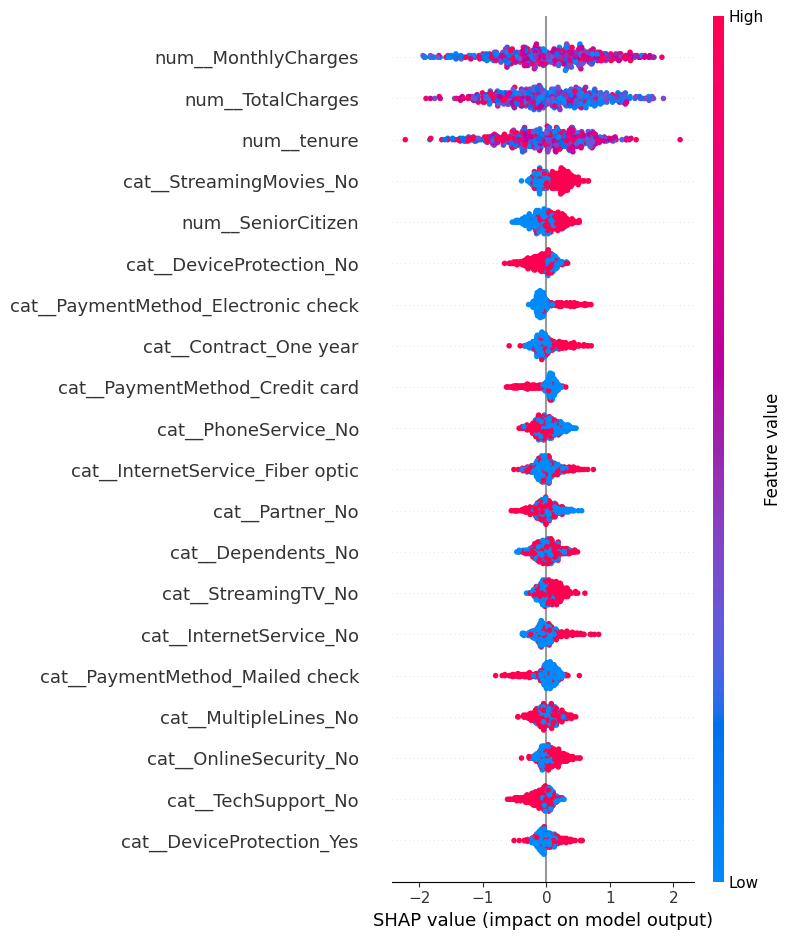

C:\Users\allur\AppData\Local\Temp\ipykernel_17312\3476304344.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_sample_trans, feature_names=feat_names, plot_type="bar", show=False)


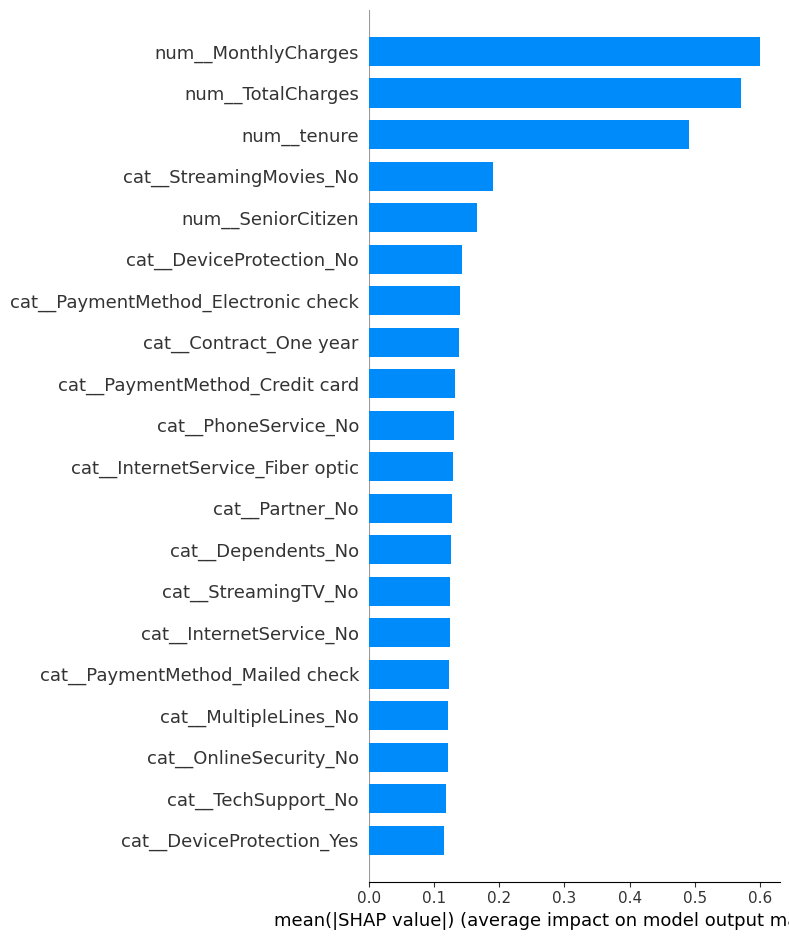

<Figure size 640x480 with 0 Axes>

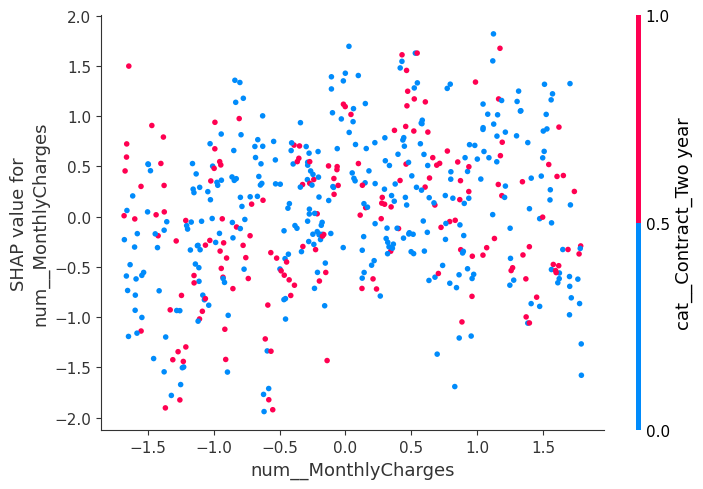


Saved plots:
 - reports/figures/shap_summary_beeswarm.png
 - reports/figures/shap_feature_importance.png
 - reports/figures/shap_dependence_num__MonthlyCharges.png


In [2]:
# === Sprint 3 · Cell 2: SHAP analysis & plots ===
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure SHAP plots render nicely
shap.initjs()

# 1) Create SHAP explainer (TreeExplainer is optimized for XGBoost)
explainer = shap.TreeExplainer(xgb_model)

# 2) Compute SHAP values for the sample (fast on 500 rows)
shap_values = explainer(X_sample_trans)

# 3) Summary beeswarm plot (global impact, color = feature value)
plt.figure()
shap.summary_plot(shap_values, features=X_sample_trans, feature_names=feat_names, show=False)
os.makedirs("reports/figures", exist_ok=True)
plt.tight_layout()
plt.savefig("reports/figures/shap_summary_beeswarm.png", dpi=150)
plt.show()

# 4) Bar plot of mean(|SHAP value|) — global feature importance
plt.figure()
shap.summary_plot(shap_values, features=X_sample_trans, feature_names=feat_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("reports/figures/shap_feature_importance.png", dpi=150)
plt.show()

# 5) Dependence plot for the most important feature
top_feature = feat_names[np.argsort(np.abs(shap_values.values).mean(0))[-1]]
plt.figure()
shap.dependence_plot(top_feature, shap_values.values, X_sample_trans, feature_names=feat_names, show=False)
plt.tight_layout()
plt.savefig(f"reports/figures/shap_dependence_{top_feature}.png", dpi=150)
plt.show()

print("\nSaved plots:")
print(" - reports/figures/shap_summary_beeswarm.png")
print(" - reports/figures/shap_feature_importance.png")
print(f" - reports/figures/shap_dependence_{top_feature}.png")
